# Final Project
Logan Cooper

In [49]:
import pandas as pd
import numpy as np
import gc
from tqdm.auto import tqdm
import statsmodels.formula.api as smf
from statsmodels.regression.linear_model import OLSResults
from typing import Tuple
import geopandas

## Data

### Data Import

#### NCDB Building Age Data (2000)

In [50]:
ncdb_dtypes = {
    'tract_id': str,
    'workers_taking_transit': int,
    'prop_taking_transit': float,
    'built_1999_2000': int,
    'built_1995_1998': int,
    'built_1990_1994': int,
    'built_1980_1989': int,
    'built_1970_79': int,
    'built_1960_69': int,
    'built_1950_59': int,
    'built_1940_49': int,
    'built_1939_earlier': int
}
ncdb_data = pd.read_csv('./data/NCDB_2000.csv', dtype=ncdb_dtypes)
ncdb_data

,tract_id,workers_taking_transit,prop_taking_transit,built_1999_2000,built_1995_1998,built_1990_1994,built_1980_1989,built_1970_1979,built_1960_1969,built_1950_1959,built_1940_1949,built_1939_earlier
0,1001020100,0,0.000000,28,71,67,137,214,94,59,33,39
1,1001020200,0,0.000000,21,47,39,102,220,83,75,52,119
2,1001020300,0,0.000000,24,176,72,150,389,328,31,54,39
3,1001020400,11,0.005186,11,78,103,159,541,639,306,24,10
4,1001020500,0,0.000000,119,581,504,431,491,115,36,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...
65438,56043000200,2,0.001519,2,133,58,301,398,72,144,48,189
65439,56043000301,0,0.000000,0,0,29,30,91,60,518,305,241
65440,56043000302,0,0.000000,7,29,27,152,487,82,152,39,60
65441,56045951100,57,0.045820,64,101,81,280,412,124,139,113,180


In [51]:
ncdb_data[ncdb_data['tract_id'].str.startswith('6')]

,tract_id,workers_taking_transit,prop_taking_transit,built_1999_2000,built_1995_1998,built_1990_1994,built_1980_1989,built_1970_1979,built_1960_1969,built_1950_1959,built_1940_1949,built_1939_earlier
2970,6001400100,124,0.091988,48,230,401,56,76,54,95,69,122
2971,6001400200,258,0.232014,0,0,10,18,26,62,31,94,658
2972,6001400300,700,0.226904,7,29,8,49,255,179,206,206,1628
2973,6001400400,450,0.204360,0,13,0,43,88,139,222,146,1229
2974,6001400500,395,0.213629,0,4,5,40,57,133,216,226,920
...,...,...,...,...,...,...,...,...,...,...,...,...
10014,6115040800,0,0.000000,22,54,127,209,231,182,132,57,135
10015,6115040901,5,0.005688,43,29,183,201,153,99,69,52,61
10016,6115040902,18,0.006529,7,123,46,176,303,685,436,67,7
10017,6115041000,6,0.002308,49,140,394,548,629,237,177,120,158


In [52]:
ncdb_data['pub_trans_gt_10pct'] = 0
ncdb_data['pub_trans_gt_10pct'][ncdb_data['prop_taking_transit'] >= 0.1] = 1
ncdb_data

/tmp/ipykernel_2697/1206332841.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ncdb_data['pub_trans_gt_10pct'][ncdb_data['prop_taking_transit'] >= 0.1] = 1


,tract_id,workers_taking_transit,prop_taking_transit,built_1999_2000,built_1995_1998,built_1990_1994,built_1980_1989,built_1970_1979,built_1960_1969,built_1950_1959,built_1940_1949,built_1939_earlier,pub_trans_gt_10pct
0,1001020100,0,0.000000,28,71,67,137,214,94,59,33,39,0
1,1001020200,0,0.000000,21,47,39,102,220,83,75,52,119,0
2,1001020300,0,0.000000,24,176,72,150,389,328,31,54,39,0
3,1001020400,11,0.005186,11,78,103,159,541,639,306,24,10,0
4,1001020500,0,0.000000,119,581,504,431,491,115,36,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
65438,56043000200,2,0.001519,2,133,58,301,398,72,144,48,189,0
65439,56043000301,0,0.000000,0,0,29,30,91,60,518,305,241,0
65440,56043000302,0,0.000000,7,29,27,152,487,82,152,39,60,0
65441,56045951100,57,0.045820,64,101,81,280,412,124,139,113,180,0


In [53]:
ncdb_data[ncdb_data['tract_id'].str.startswith('6')]

,tract_id,workers_taking_transit,prop_taking_transit,built_1999_2000,built_1995_1998,built_1990_1994,built_1980_1989,built_1970_1979,built_1960_1969,built_1950_1959,built_1940_1949,built_1939_earlier,pub_trans_gt_10pct
2970,6001400100,124,0.091988,48,230,401,56,76,54,95,69,122,0
2971,6001400200,258,0.232014,0,0,10,18,26,62,31,94,658,1
2972,6001400300,700,0.226904,7,29,8,49,255,179,206,206,1628,1
2973,6001400400,450,0.204360,0,13,0,43,88,139,222,146,1229,1
2974,6001400500,395,0.213629,0,4,5,40,57,133,216,226,920,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
10014,6115040800,0,0.000000,22,54,127,209,231,182,132,57,135,0
10015,6115040901,5,0.005688,43,29,183,201,153,99,69,52,61,0
10016,6115040902,18,0.006529,7,123,46,176,303,685,436,67,7,0
10017,6115041000,6,0.002308,49,140,394,548,629,237,177,120,158,0


In [54]:
ncdb_data['pub_trans_gt_10pct'].value_counts()

0    55450
1     9993
Name: pub_trans_gt_10pct, dtype: int64

In [55]:
ncdb_data

,tract_id,workers_taking_transit,prop_taking_transit,built_1999_2000,built_1995_1998,built_1990_1994,built_1980_1989,built_1970_1979,built_1960_1969,built_1950_1959,built_1940_1949,built_1939_earlier,pub_trans_gt_10pct
0,1001020100,0,0.000000,28,71,67,137,214,94,59,33,39,0
1,1001020200,0,0.000000,21,47,39,102,220,83,75,52,119,0
2,1001020300,0,0.000000,24,176,72,150,389,328,31,54,39,0
3,1001020400,11,0.005186,11,78,103,159,541,639,306,24,10,0
4,1001020500,0,0.000000,119,581,504,431,491,115,36,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
65438,56043000200,2,0.001519,2,133,58,301,398,72,144,48,189,0
65439,56043000301,0,0.000000,0,0,29,30,91,60,518,305,241,0
65440,56043000302,0,0.000000,7,29,27,152,487,82,152,39,60,0
65441,56045951100,57,0.045820,64,101,81,280,412,124,139,113,180,0


#### Tract Level Data (2019)

In [56]:
# import & rename cols
tract_data_2019 = pd.read_json('./data/tract_data_2019.json', dtype=False)
tract_data_2019.rename({
    'B19019_001E': 'median_income',
    'B01003_001E': 'population'
}, inplace=True, axis=1)

tract_data_2019['tract_id'] = tract_data_2019['state'] + tract_data_2019['county'] + tract_data_2019['tract']
tract_data_2019

,median_income,population,state,county,tract,tract_id
0,37030.0,4781.0,01,073,001100,01073001100
1,36066.0,1946.0,01,073,001400,01073001400
2,27159.0,4080.0,01,073,002000,01073002000
3,38721.0,5291.0,01,073,003802,01073003802
4,18525.0,2533.0,01,073,004000,01073004000
...,...,...,...,...,...,...
72872,87794.0,4187.0,56,021,001902,56021001902
72873,-666666666.0,0.0,56,021,980801,56021980801
72874,85194.0,7513.0,56,025,001602,56025001602
72875,120564.0,3724.0,56,025,001603,56025001603


In [57]:
tract_data_2019['state'].value_counts().sort_index()

01    1181
02     167
04    1526
05     686
06    8057
08    1249
09     833
10     218
12    4245
13    1969
15     351
16     298
17    3123
18    1511
19     825
20     770
21    1115
22    1148
23     358
24    1406
25    1478
26    2813
27    1338
28     664
29    1393
30     271
31     532
32     687
33     295
34    2010
35     499
36    4918
37    2195
38     205
39    2952
40    1046
41     834
42    3218
44     244
45    1103
46     222
47    1497
48    5265
49     588
50     184
51    1907
53    1458
54     484
55    1409
56     132
Name: state, dtype: int64

#### MSA-Level Income Data (2019)

In [86]:
msa_data = pd.read_json('./data/msa_data.json')
msa_data.columns = ['name', 'median_income', 'msa_code']
msa_data['msa_code'] = msa_data['msa_code'].astype(str)
msa_data

,name,median_income,msa_code
1,"Billings, MT Metro Area",61278,13740
2,"Binghamton, NY Metro Area",54295,13780
3,"Birmingham-Hoover, AL Metro Area",57447,13820
4,"Bismarck, ND Metro Area",71398,13900
6,"Blacksburg-Christiansburg, VA Metro Area",55065,13980
...,...,...,...
928,"Youngstown-Warren-Boardman, OH-PA Metro Area",47360,49660
929,"Yuba City, CA Metro Area",58551,49700
930,"Yuma, AZ Metro Area",45243,49740
935,"Orlando-Kissimmee-Sanford, FL Metro Area",58368,36740


In [84]:
msa_data = msa_data[msa_data['name'].str.contains('Metro Area')]
msa_data

,name,median_income,msa_code
1,"Billings, MT Metro Area",61278,13740
2,"Binghamton, NY Metro Area",54295,13780
3,"Birmingham-Hoover, AL Metro Area",57447,13820
4,"Bismarck, ND Metro Area",71398,13900
6,"Blacksburg-Christiansburg, VA Metro Area",55065,13980
...,...,...,...
928,"Youngstown-Warren-Boardman, OH-PA Metro Area",47360,49660
929,"Yuba City, CA Metro Area",58551,49700
930,"Yuma, AZ Metro Area",45243,49740
935,"Orlando-Kissimmee-Sanford, FL Metro Area",58368,36740


In [97]:
# derived from an earlier notebook version where these MSA IDs turned up missing
# anything not in here is either in Puerto Rico or isn't an MSA in at least one period
changed_msa_ids = ['19380','29140','42260','31100','22460','11340','11300','14060','42060','26180','23020','39140']
changed_msa_names = ['Dayton-Kettering, OH Metro Area', 
                     'Lafayette-West Lafayette, IN Metro Area', 
                     'North Port-Sarasota-Bradenton, FL Metro Area',
                     'Los Angeles-Long Beach-Anaheim, CA Metro Area',
                     'Florence-Muscle Shoals, AL Metro Area',
                     'Greenville-Anderson, SC Metro Area',
                     'Indianapolis-Carmel-Anderson, IN Metro Area',
                     'Bloomington, IL Metro Area',
                     'Santa Maria-Santa Barbara, CA Metro Area',
                     'Urban Honolulu, HI Metro Area',
                     'Crestview-Fort Walton Beach-Destin, FL Metro Area',
                     'Prescott Valley-Prescott, AZ Metro Area']

msa_data.loc[msa_data['name'].isin(changed_msa_names), 'msa_code'] = changed_msa_ids
msa_data[msa_data['msa_code'].isin(changed_msa_ids)]


,name,median_income,msa_code
7,"Bloomington, IL Metro Area",67675,19380
120,"Crestview-Fort Walton Beach-Destin, FL Metro Area",62161,29140
144,"Dayton-Kettering, OH Metro Area",55634,42260
212,"Florence-Muscle Shoals, AL Metro Area",48084,31100
260,"Greenville-Anderson, SC Metro Area",54886,22460
310,"Indianapolis-Carmel-Anderson, IN Metro Area",61552,11340
497,"Prescott Valley-Prescott, AZ Metro Area",52451,11300
585,"Santa Maria-Santa Barbara, CA Metro Area",74624,14060
672,"Urban Honolulu, HI Metro Area",85857,42060
722,"Lafayette-West Lafayette, IN Metro Area",53321,26180


In [85]:
msa_data.to_json('./data/msa_data.json')

#### MSA-Tract Crosswalk

In [60]:
msa_lookup = pd.read_excel('./data/omb-cbsa-csa.xls')
msa_lookup = msa_lookup.iloc[2:].dropna(axis=1).iloc[:, [0, 2, -1]].reset_index(drop=True).dropna()
msa_lookup.columns = ['CBSA Code', 'Metropolitan/Micropolitan Statistical Area', 'FIPS Code']

for c in msa_lookup.columns:
    msa_lookup[c] = msa_lookup[c].astype(str)

msa_lookup

,CBSA Code,Metropolitan/Micropolitan Statistical Area,FIPS Code
0,10020,Micropolitan Statistical Area,22113
1,10100,Micropolitan Statistical Area,46013
2,10100,Micropolitan Statistical Area,46045
3,10140,Micropolitan Statistical Area,53027
4,10180,Metropolitan Statistical Area,48059
...,...,...,...
1832,49660,Metropolitan Statistical Area,42085
1833,49700,Metropolitan Statistical Area,06101
1834,49700,Metropolitan Statistical Area,06115
1835,49740,Metropolitan Statistical Area,04027


In [61]:
msa_lookup['FIPS State Code'] = msa_lookup['FIPS Code'].str[:2]
msa_lookup['FIPS County Code'] = msa_lookup['FIPS Code'].str[2:]
msa_lookup.drop('FIPS Code', axis=1, inplace=True)
msa_lookup

,CBSA Code,Metropolitan/Micropolitan Statistical Area,FIPS State Code,FIPS County Code
0,10020,Micropolitan Statistical Area,22,113
1,10100,Micropolitan Statistical Area,46,013
2,10100,Micropolitan Statistical Area,46,045
3,10140,Micropolitan Statistical Area,53,027
4,10180,Metropolitan Statistical Area,48,059
...,...,...,...,...
1832,49660,Metropolitan Statistical Area,42,085
1833,49700,Metropolitan Statistical Area,06,101
1834,49700,Metropolitan Statistical Area,06,115
1835,49740,Metropolitan Statistical Area,04,027


In [62]:
og_msas = msa_lookup[msa_lookup['Metropolitan/Micropolitan Statistical Area'] == 'Metropolitan Statistical Area']['CBSA Code'].value_counts().index
og_msas

Index(['41980', '12060', '35620', '47900', '40060', '47260', '41180', '17140',
       '28140', '16980',
       ...
       '19660', '20100', '34580', '34620', '34740', '34820', '34900', '34940',
       '35300', '49740'],
      dtype='object', length=370)

In [63]:
# msa_lookup = pd.read_excel('./data/msa_codes.xls', 
#                            converters={'CBSA Code': str, 
#                                        'CBSA Title': str, 
#                                        'Metropolitan/Micropolitan Statistical Area': str, 
#                                        'FIPS State Code': str,
#                                        'FIPS County Code': str}
#                            ).drop(range(1916,1920))

# msa_lookup

#### Conversion for 2000 => 2010

In [64]:
tract_conversion = pd.read_csv('./data/us2010trf.txt')
tract_conversion

,STATE00,COUNTY00,TRACT00,GEOID00,POP00,HU00,PART00,AREA00,AREALAND00,STATE10,...,AREAPCT00PT,AREALANDPCT00PT,AREAPCT10PT,AREALANDPCT10PT,POP10PT,POPPCT00,POPPCT10,HU10PT,HUPCT00,HUPCT10
0,1,1,20100,1001020100,1913,753,P,9846943,9810183,1,...,99.99,100.00,100.00,100.00,1912,99.95,100.00,752,99.87,100.00
1,1,1,20100,1001020100,1913,753,P,9846943,9810183,1,...,0.01,0.00,0.01,0.00,0,0.00,0.00,0,0.00,0.00
2,1,1,20100,1001020100,1913,753,P,9846943,9810183,1,...,0.00,0.00,0.00,0.00,1,0.05,0.01,1,0.13,0.02
3,1,1,20200,1001020200,2170,822,W,3346351,3340505,1,...,100.00,100.00,100.00,100.00,2170,100.00,100.00,822,100.00,100.00
4,1,1,20300,1001020300,3373,1326,W,5358328,5349274,1,...,100.00,100.00,100.00,100.00,3373,100.00,100.00,1326,100.00,100.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
110849,72,153,750601,72153750601,5315,2106,P,11040535,11035996,72,...,99.79,99.79,100.00,100.00,5315,100.00,100.00,2106,100.00,100.00
110850,72,153,750601,72153750601,5315,2106,P,11040535,11035996,72,...,0.21,0.21,0.13,0.13,0,0.00,0.00,0,0.00,0.00
110851,72,153,750602,72153750602,3141,1450,P,17773730,17520777,72,...,0.04,0.04,0.05,0.05,0,0.00,0.00,0,0.00,0.00
110852,72,153,750602,72153750602,3141,1450,P,17773730,17520777,72,...,0.06,0.07,0.04,0.05,0,0.00,0.00,0,0.00,0.00


In [65]:
tract_conversion.columns

Index(['STATE00', 'COUNTY00', 'TRACT00', 'GEOID00', 'POP00', 'HU00', 'PART00',
       'AREA00', 'AREALAND00', 'STATE10', 'COUNTY10', 'TRACT10', 'GEOID10',
       'POP10', 'HU10', 'PART10', 'AREA10', 'AREALAND10', 'AREAPT',
       'AREALANDPT', 'AREAPCT00PT', 'AREALANDPCT00PT', 'AREAPCT10PT',
       'AREALANDPCT10PT', 'POP10PT', 'POPPCT00', 'POPPCT10', 'HU10PT',
       'HUPCT00', 'HUPCT10'],
      dtype='object')

In [66]:
tract_conversion = tract_conversion[['GEOID00', 'GEOID10', 'AREALAND10']]
tract_conversion['GEOID00'] = tract_conversion['GEOID00'].astype(str)
tract_conversion['GEOID10'] = tract_conversion['GEOID10'].astype(str)
tract_conversion

/tmp/ipykernel_2697/1172295500.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tract_conversion['GEOID00'] = tract_conversion['GEOID00'].astype(str)
/tmp/ipykernel_2697/1172295500.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tract_conversion['GEOID10'] = tract_conversion['GEOID10'].astype(str)


,GEOID00,GEOID10,AREALAND10
0,1001020100,1001020100,9809944
1,1001020100,1001020600,8020366
2,1001020100,1001020802,190810921
3,1001020200,1001020200,3340505
4,1001020300,1001020300,5349274
...,...,...,...
110849,72153750601,72153750601,11012462
110850,72153750601,72153750602,17526535
110851,72153750602,72055960900,13138821
110852,72153750602,72055961100,24581786


In [67]:
# AREALAND10 is in square meters, want it in square miles
tract_conversion['AREALAND10'] = tract_conversion['AREALAND10'] * 3.861e-7
tract_conversion = tract_conversion[tract_conversion['AREALAND10'] > 0]
tract_conversion

/tmp/ipykernel_2697/534912662.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tract_conversion['AREALAND10'] = tract_conversion['AREALAND10'] * 3.861e-7


,GEOID00,GEOID10,AREALAND10
0,1001020100,1001020100,3.787619
1,1001020100,1001020600,3.096663
2,1001020100,1001020802,73.672097
3,1001020200,1001020200,1.289769
4,1001020300,1001020300,2.065355
...,...,...,...
110849,72153750601,72153750601,4.251912
110850,72153750601,72153750602,6.766995
110851,72153750602,72055960900,5.072899
110852,72153750602,72055961100,9.491028


#### Tract-School District Crosswalk

In [68]:
school_districts = pd.read_excel('./data/grf19_lea_tract.xlsx')
# school_districts.drop(['NAME_LEA19', 'COUNT', 'LANDAREA', 'WATERAREA'], axis=1, inplace=True)
school_districts['LEAID'] = school_districts['LEAID'].astype(str)
school_districts['TRACT'] = school_districts['TRACT'].astype(str)
school_districts

,LEAID,NAME_LEA19,TRACT,COUNT,LANDAREA,WATERAREA
0,100001,Fort Rucker School District,1031010300,2,23.428498,0.000000
1,100001,Fort Rucker School District,1045020000,2,66.513225,1.081745
2,100003,Maxwell AFB School District,1101000900,3,3.356590,0.143795
3,100003,Maxwell AFB School District,1101001000,3,0.001526,0.000000
4,100003,Maxwell AFB School District,1101006000,3,0.003588,0.000000
...,...,...,...,...,...,...
113515,7800030,Virgin Islands Department of Education,78030960900,32,3.147245,1.173777
113516,7800030,Virgin Islands Department of Education,78030961000,32,0.812847,0.910606
113517,7800030,Virgin Islands Department of Education,78030961100,32,1.356638,0.000000
113518,7800030,Virgin Islands Department of Education,78030961200,32,0.392958,0.309706


#### Wilson CBD

In [69]:
wilson_cbd = pd.read_csv('./data/wilson_cbd.csv', index_col=False, dtype={'msa_id': str, 'wilson_cbd': str})
wilson_cbd

,msa_id,wilson_cbd
0,10180,48441011000
1,10420,39153508301
2,10500,13095011400
3,10580,36001001100
4,10740,35001002100
...,...,...
363,49420,53077000100
364,49620,42133000100
365,49660,39099813700
366,49700,06101050604


## Data Combination

#### Trim Tract Level Data to MSAs Only

In [70]:
only_metros = msa_lookup[msa_lookup['Metropolitan/Micropolitan Statistical Area'] == 'Metropolitan Statistical Area']
msa_tracts = pd.merge(left=tract_data_2019, right=only_metros, left_on=['state', 'county'], right_on=['FIPS State Code', 'FIPS County Code'])
msa_tracts

,median_income,population,state,county,tract,tract_id,CBSA Code,Metropolitan/Micropolitan Statistical Area,FIPS State Code,FIPS County Code
0,37030.0,4781.0,01,073,001100,01073001100,13820,Metropolitan Statistical Area,01,073
1,36066.0,1946.0,01,073,001400,01073001400,13820,Metropolitan Statistical Area,01,073
2,27159.0,4080.0,01,073,002000,01073002000,13820,Metropolitan Statistical Area,01,073
3,38721.0,5291.0,01,073,003802,01073003802,13820,Metropolitan Statistical Area,01,073
4,18525.0,2533.0,01,073,004000,01073004000,13820,Metropolitan Statistical Area,01,073
...,...,...,...,...,...,...,...,...,...,...
59652,73795.0,4105.0,56,021,001401,56021001401,16940,Metropolitan Statistical Area,56,021
59653,65192.0,2671.0,56,021,001402,56021001402,16940,Metropolitan Statistical Area,56,021
59654,98949.0,5088.0,56,021,001901,56021001901,16940,Metropolitan Statistical Area,56,021
59655,87794.0,4187.0,56,021,001902,56021001902,16940,Metropolitan Statistical Area,56,021


In [71]:
msa_tracts = msa_tracts[(msa_tracts['median_income'] >= 0) & (msa_tracts['population'] > 0)]
msa_tracts

,median_income,population,state,county,tract,tract_id,CBSA Code,Metropolitan/Micropolitan Statistical Area,FIPS State Code,FIPS County Code
0,37030.0,4781.0,01,073,001100,01073001100,13820,Metropolitan Statistical Area,01,073
1,36066.0,1946.0,01,073,001400,01073001400,13820,Metropolitan Statistical Area,01,073
2,27159.0,4080.0,01,073,002000,01073002000,13820,Metropolitan Statistical Area,01,073
3,38721.0,5291.0,01,073,003802,01073003802,13820,Metropolitan Statistical Area,01,073
4,18525.0,2533.0,01,073,004000,01073004000,13820,Metropolitan Statistical Area,01,073
...,...,...,...,...,...,...,...,...,...,...
59651,79224.0,8092.0,56,021,000501,56021000501,16940,Metropolitan Statistical Area,56,021
59652,73795.0,4105.0,56,021,001401,56021001401,16940,Metropolitan Statistical Area,56,021
59653,65192.0,2671.0,56,021,001402,56021001402,16940,Metropolitan Statistical Area,56,021
59654,98949.0,5088.0,56,021,001901,56021001901,16940,Metropolitan Statistical Area,56,021


In [72]:
msa_tracts['state'].value_counts().sort_index()

01     820
02      98
04    1342
05     391
06    7766
08    1048
09     747
10     161
12    3888
13    1520
15     229
16     181
17    2636
18    1152
19     423
20     452
21     623
22     850
23     188
24    1313
25    1445
26    2213
27     929
28     283
29     981
30      79
31     295
32     607
33     174
34    1992
35     325
36    4375
37    1491
38      75
39    2411
40     681
41     619
42    2688
44     240
45     829
46      88
47    1070
48    4432
49     515
50      46
51    1605
53    1241
54     267
55     990
56      38
Name: state, dtype: int64

In [73]:
msa_tracts['CBSA Code'].value_counts()

35620    4447
31100    2890
16980    2201
37980    1460
19100    1310
         ... 
14980      17
25980      16
30300      16
18020      15
16180      13
Name: CBSA Code, Length: 362, dtype: int64

In [74]:
pr_msas = [el for el in og_msas if (el not in msa_tracts['CBSA Code'].value_counts().index)] #okay looks like these are all in PR
pr_msas

['41980', '10380', '49500', '41900', '25020', '38660', '21940', '32420']

In [75]:
msa_tracts.columns

Index(['median_income', 'population', 'state', 'county', 'tract', 'tract_id',
       'CBSA Code', 'Metropolitan/Micropolitan Statistical Area',
       'FIPS State Code', 'FIPS County Code'],
      dtype='object')

In [76]:
msa_tracts.drop(['Metropolitan/Micropolitan Statistical Area', 'FIPS State Code', 'FIPS County Code'], axis=1, inplace=True)
msa_tracts

/tmp/ipykernel_2697/1112801136.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  msa_tracts.drop(['Metropolitan/Micropolitan Statistical Area', 'FIPS State Code', 'FIPS County Code'], axis=1, inplace=True)


,median_income,population,state,county,tract,tract_id,CBSA Code
0,37030.0,4781.0,01,073,001100,01073001100,13820
1,36066.0,1946.0,01,073,001400,01073001400,13820
2,27159.0,4080.0,01,073,002000,01073002000,13820
3,38721.0,5291.0,01,073,003802,01073003802,13820
4,18525.0,2533.0,01,073,004000,01073004000,13820
...,...,...,...,...,...,...,...
59651,79224.0,8092.0,56,021,000501,56021000501,16940
59652,73795.0,4105.0,56,021,001401,56021001401,16940
59653,65192.0,2671.0,56,021,001402,56021001402,16940
59654,98949.0,5088.0,56,021,001901,56021001901,16940


In [77]:
del only_metros
gc.collect()

113646

#### Merge MSA-Level Data

In [78]:
msa_tracts = pd.merge(left=msa_tracts, right=msa_data, left_on='CBSA Code', right_on='msa_code', suffixes=('_tract', '_msa'))
msa_tracts['income'] = msa_tracts['median_income_tract'] / msa_tracts['median_income_msa']
msa_tracts.drop(['CBSA Code', 'median_income_tract', 'median_income_msa'], axis=1, inplace=True)
msa_tracts

,population,state,county,tract,tract_id,msa_code,income
0,4781.0,01,073,001100,01073001100,13820,0.644594
1,1946.0,01,073,001400,01073001400,13820,0.627813
2,4080.0,01,073,002000,01073002000,13820,0.472766
3,5291.0,01,073,003802,01073003802,13820,0.674030
4,2533.0,01,073,004000,01073004000,13820,0.322471
...,...,...,...,...,...,...,...
54838,8092.0,56,021,000501,56021000501,16940,1.184038
54839,4105.0,56,021,001401,56021001401,16940,1.102899
54840,2671.0,56,021,001402,56021001402,16940,0.974324
54841,5088.0,56,021,001901,56021001901,16940,1.478837


In [79]:
[el for el in og_msas if (el not in msa_tracts['msa_code'].value_counts().index) and (el not in pr_msas)]

['19380',
 '29140',
 '14980',
 '42260',
 '31100',
 '37700',
 '22460',
 '11340',
 '11300',
 '46940',
 '14060',
 '42060',
 '26100',
 '26180',
 '23020',
 '39140']

In [110]:
msa_tracts['state'].value_counts().sort_index()

01     784
02      98
04    1300
05     391
06    4789
08    1048
09     747
10     161
12    3646
13    1520
16     181
17    2595
18    1071
19     423
20     452
21     623
22     850
23     188
24    1313
25    1445
26    2160
27     929
28     250
29     981
30      79
31     295
32     607
33     174
34    1992
35     325
36    4375
37    1491
38      75
39    2192
40     681
41     619
42    2688
44     240
45     790
46      88
47    1070
48    4432
49     515
50      46
51    1588
53    1241
54     267
55     990
56      38
Name: state, dtype: int64

In [111]:
# msa_tracts[msa_tracts['tract_id'].str.startswith('0')]['tract_id'] = msa_tracts[msa_tracts['tract_id'].str.startswith('0')]['tract_id'].str[1:]

In [112]:
del msa_data
gc.collect()

0

#### Convert 2000-Tracts and Merge

In [113]:
ages_2019 = pd.merge(left=ncdb_data, right=tract_conversion, left_on='tract_id', right_on='GEOID00')
ages_2019.drop(['tract_id', 'workers_taking_transit', 'prop_taking_transit'], axis=1, inplace=True)
ages_2019.rename({'AREALAND10': 'area', 'GEOID10': 'tract_id_2010', 'GEOID00': 'tract_id_2000'}, inplace=True, axis=1)

ages_2019

,built_1999_2000,built_1995_1998,built_1990_1994,built_1980_1989,built_1970_1979,built_1960_1969,built_1950_1959,built_1940_1949,built_1939_earlier,pub_trans_gt_10pct,tract_id_2000,tract_id_2010,area
0,28,71,67,137,214,94,59,33,39,0,1001020100,1001020100,3.787619
1,28,71,67,137,214,94,59,33,39,0,1001020100,1001020600,3.096663
2,28,71,67,137,214,94,59,33,39,0,1001020100,1001020802,73.672097
3,21,47,39,102,220,83,75,52,119,0,1001020200,1001020200,1.289769
4,24,176,72,150,389,328,31,54,39,0,1001020300,1001020300,2.065355
...,...,...,...,...,...,...,...,...,...,...,...,...,...
108049,7,29,27,152,487,82,152,39,60,0,56043000302,56043000302,5.894123
108050,64,101,81,280,412,124,139,113,180,0,56045951100,46033965100,1524.284426
108051,64,101,81,280,412,124,139,113,180,0,56045951100,56011950200,2008.869910
108052,64,101,81,280,412,124,139,113,180,0,56045951100,56045951100,2355.294496


In [114]:
non_aggregated_tract_data = ages_2019[['tract_id_2010', 'area']].drop_duplicates()
non_aggregated_tract_data

,tract_id_2010,area
0,1001020100,3.787619
1,1001020600,3.096663
2,1001020802,73.672097
3,1001020200,1.289769
4,1001020300,2.065355
...,...,...
108045,56041975400,51.087489
108047,56043000301,0.769575
108048,56043000302,5.894123
108052,56045951100,2355.294496


In [115]:
summed_ages = ages_2019.groupby('tract_id_2010').sum(numeric_only=True).drop(['area'], axis=1).reset_index()
summed_ages

,tract_id_2010,built_1999_2000,built_1995_1998,built_1990_1994,built_1980_1989,built_1970_1979,built_1960_1969,built_1950_1959,built_1940_1949,built_1939_earlier,pub_trans_gt_10pct
0,10001040100,74,238,301,502,450,126,46,33,134,0
1,10001040201,61,114,87,105,299,229,131,87,336,0
2,10001040202,41,198,211,368,364,242,163,94,339,0
3,10001040203,16,223,191,207,163,152,145,34,95,0
4,10001040501,175,527,413,404,786,789,294,89,126,0
...,...,...,...,...,...,...,...,...,...,...,...
72734,9015906100,26,197,249,769,742,519,327,166,800,0
72735,9015907100,27,133,139,472,502,454,334,209,1373,0
72736,9015907200,0,72,66,210,320,275,235,117,733,0
72737,9015907300,14,100,90,398,322,346,148,121,494,0


In [116]:
summed_ages['pub_trans_gt_10pct'] = (summed_ages['pub_trans_gt_10pct'] >= 1).astype(int)
summed_ages

,tract_id_2010,built_1999_2000,built_1995_1998,built_1990_1994,built_1980_1989,built_1970_1979,built_1960_1969,built_1950_1959,built_1940_1949,built_1939_earlier,pub_trans_gt_10pct
0,10001040100,74,238,301,502,450,126,46,33,134,0
1,10001040201,61,114,87,105,299,229,131,87,336,0
2,10001040202,41,198,211,368,364,242,163,94,339,0
3,10001040203,16,223,191,207,163,152,145,34,95,0
4,10001040501,175,527,413,404,786,789,294,89,126,0
...,...,...,...,...,...,...,...,...,...,...,...
72734,9015906100,26,197,249,769,742,519,327,166,800,0
72735,9015907100,27,133,139,472,502,454,334,209,1373,0
72736,9015907200,0,72,66,210,320,275,235,117,733,0
72737,9015907300,14,100,90,398,322,346,148,121,494,0


In [117]:
summed_ages.describe()

,built_1999_2000,built_1995_1998,built_1990_1994,built_1980_1989,built_1970_1979,built_1960_1969,built_1950_1959,built_1940_1949,built_1939_earlier,pub_trans_gt_10pct
count,72739.000000,72739.000000,72739.000000,72739.000000,72739.000000,72739.000000,72739.000000,72739.000000,72739.000000,72739.000000
mean,86.584075,255.289171,241.975831,490.126782,528.749804,370.581298,331.683045,186.090983,388.802293,0.152325
std,169.292508,410.716050,331.594439,578.283644,508.355353,351.777010,352.244631,214.831011,553.901444,0.359339
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,5.000000,24.000000,33.000000,105.000000,173.000000,134.000000,102.000000,44.000000,44.000000,0.000000
50%,28.000000,106.000000,121.000000,298.000000,389.000000,271.000000,228.000000,124.000000,188.000000,0.000000
75%,96.000000,320.000000,322.000000,674.000000,728.000000,495.000000,439.000000,251.000000,519.000000,0.000000
max,4918.000000,8456.000000,4639.000000,11267.000000,10034.000000,8417.000000,5537.000000,8296.000000,10131.000000,1.000000


In [118]:
msa_tracts['tract_id'] = msa_tracts['tract_id'].str.removeprefix('0')
msa_tracts['tract_id']

0         1073001100
1         1073001400
2         1073002000
3         1073003802
4         1073004000
            ...     
54838    56021000501
54839    56021001401
54840    56021001402
54841    56021001901
54842    56021001902
Name: tract_id, Length: 54843, dtype: object

In [119]:
ages_2019 = pd.merge(left=summed_ages, right=non_aggregated_tract_data)
ages_2019

,tract_id_2010,built_1999_2000,built_1995_1998,built_1990_1994,built_1980_1989,built_1970_1979,built_1960_1969,built_1950_1959,built_1940_1949,built_1939_earlier,pub_trans_gt_10pct,area
0,10001040100,74,238,301,502,450,126,46,33,134,0,48.164373
1,10001040201,61,114,87,105,299,229,131,87,336,0,3.757499
2,10001040202,41,198,211,368,364,242,163,94,339,0,12.333051
3,10001040203,16,223,191,207,163,152,145,34,95,0,22.927105
4,10001040501,175,527,413,404,786,789,294,89,126,0,4.040981
...,...,...,...,...,...,...,...,...,...,...,...,...
72734,9015906100,26,197,249,769,742,519,327,166,800,0,39.944555
72735,9015907100,27,133,139,472,502,454,334,209,1373,0,13.248126
72736,9015907200,0,72,66,210,320,275,235,117,733,0,13.477847
72737,9015907300,14,100,90,398,322,346,148,121,494,0,15.633260


In [120]:
ages_2019.describe()

,built_1999_2000,built_1995_1998,built_1990_1994,built_1980_1989,built_1970_1979,built_1960_1969,built_1950_1959,built_1940_1949,built_1939_earlier,pub_trans_gt_10pct,area
count,72739.000000,72739.000000,72739.000000,72739.000000,72739.000000,72739.000000,72739.000000,72739.000000,72739.000000,72739.000000,72739.000000
mean,86.584075,255.289171,241.975831,490.126782,528.749804,370.581298,331.683045,186.090983,388.802293,0.152325,48.555597
std,169.292508,410.716050,331.594439,578.283644,508.355353,351.777010,352.244631,214.831011,553.901444,0.359339,542.923463
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.003204
25%,5.000000,24.000000,33.000000,105.000000,173.000000,134.000000,102.000000,44.000000,44.000000,0.000000,0.694460
50%,28.000000,106.000000,121.000000,298.000000,389.000000,271.000000,228.000000,124.000000,188.000000,0.000000,1.890971
75%,96.000000,320.000000,322.000000,674.000000,728.000000,495.000000,439.000000,251.000000,519.000000,0.000000,13.309841
max,4918.000000,8456.000000,4639.000000,11267.000000,10034.000000,8417.000000,5537.000000,8296.000000,10131.000000,1.000000,85425.253710


In [121]:
msa_tracts = pd.merge(left=msa_tracts, right=ages_2019, left_on='tract_id', right_on='tract_id_2010')
msa_tracts.drop(['tract_id'], axis=1, inplace=True)

msa_tracts = msa_tracts[(msa_tracts['population'] >= 1) & (msa_tracts['income'] > 0) & (msa_tracts['area'] > 0)] # drop weird tracts

msa_tracts['pop_density'] = msa_tracts['population'] / msa_tracts['area']
msa_tracts

,population,state,county,tract,msa_code,income,tract_id_2010,built_1999_2000,built_1995_1998,built_1990_1994,built_1980_1989,built_1970_1979,built_1960_1969,built_1950_1959,built_1940_1949,built_1939_earlier,pub_trans_gt_10pct,area,pop_density
0,4781.0,01,073,001100,13820,0.644594,1073001100,41,168,118,788,1570,919,854,759,596,0,4.412472,1083.519710
1,1946.0,01,073,001400,13820,0.627813,1073001400,15,27,30,290,422,894,1393,601,1126,0,0.865361,2248.772710
2,4080.0,01,073,002000,13820,0.472766,1073002000,13,24,24,172,490,746,717,520,388,0,1.391900,2931.244740
3,5291.0,01,073,003802,13820,0.674030,1073003802,46,76,22,184,603,968,2195,919,574,0,1.252927,4222.913159
4,2533.0,01,073,004000,13820,0.322471,1073004000,18,31,66,352,617,554,207,191,244,0,0.913001,2774.367116
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
54818,8092.0,56,021,000501,16940,1.184038,56021000501,94,376,78,304,497,911,204,31,17,0,2.358055,3431.641507
54819,4105.0,56,021,001401,16940,1.102899,56021001401,68,244,155,502,867,425,195,0,18,0,1.541849,2662.387090
54820,2671.0,56,021,001402,16940,0.974324,56021001402,68,244,155,502,867,425,195,0,18,0,4.889134,546.313507
54821,5088.0,56,021,001901,16940,1.478837,56021001901,171,371,364,502,478,155,113,66,172,0,585.414185,8.691282


In [122]:
msa_tracts['state'].value_counts().sort_index()

01     784
02      98
04    1293
05     391
06    4789
08    1048
09     747
10     161
12    3646
13    1520
16     181
17    2595
18    1071
19     423
20     452
21     623
22     850
23     188
24    1313
25    1445
26    2160
27     929
28     250
29     981
30      79
31     295
32     607
33     174
34    1992
35     325
36    4363
37    1491
38      75
39    2192
40     681
41     619
42    2688
44     240
45     790
46      88
47    1070
48    4432
49     515
50      46
51    1587
53    1241
54     267
55     990
56      38
Name: state, dtype: int64

In [123]:
del ages_2019
gc.collect()

0

#### Add School District

In [124]:
msa_tracts = pd.merge(left=msa_tracts, right=school_districts, left_on='tract_id_2010', right_on='TRACT')
msa_tracts.drop(['NAME_LEA19', 'TRACT', 'COUNT', 'LANDAREA', 'WATERAREA'], axis=1, inplace=True)
msa_tracts

,population,state,county,tract,msa_code,income,tract_id_2010,built_1999_2000,built_1995_1998,built_1990_1994,built_1980_1989,built_1970_1979,built_1960_1969,built_1950_1959,built_1940_1949,built_1939_earlier,pub_trans_gt_10pct,area,pop_density,LEAID
0,4781.0,01,073,001100,13820,0.644594,1073001100,41,168,118,788,1570,919,854,759,596,0,4.412472,1083.519710,100390
1,4781.0,01,073,001100,13820,0.644594,1073001100,41,168,118,788,1570,919,854,759,596,0,4.412472,1083.519710,101920
2,1946.0,01,073,001400,13820,0.627813,1073001400,15,27,30,290,422,894,1393,601,1126,0,0.865361,2248.772710,100390
3,4080.0,01,073,002000,13820,0.472766,1073002000,13,24,24,172,490,746,717,520,388,0,1.391900,2931.244740,100390
4,4080.0,01,073,002000,13820,0.472766,1073002000,13,24,24,172,490,746,717,520,388,0,1.391900,2931.244740,101920
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
77279,4105.0,56,021,001401,16940,1.102899,56021001401,68,244,155,502,867,425,195,0,18,0,1.541849,2662.387090,5601980
77280,2671.0,56,021,001402,16940,0.974324,56021001402,68,244,155,502,867,425,195,0,18,0,4.889134,546.313507,5601980
77281,5088.0,56,021,001901,16940,1.478837,56021001901,171,371,364,502,478,155,113,66,172,0,585.414185,8.691282,5601980
77282,5088.0,56,021,001901,16940,1.478837,56021001901,171,371,364,502,478,155,113,66,172,0,585.414185,8.691282,5604120


In [125]:
del school_districts
gc.collect()

0

### Add Wilson CBD

In [126]:
wilson_cbd

,msa_id,wilson_cbd
0,10180,48441011000
1,10420,39153508301
2,10500,13095011400
3,10580,36001001100
4,10740,35001002100
...,...,...
363,49420,53077000100
364,49620,42133000100
365,49660,39099813700
366,49700,06101050604


In [127]:
msa_tracts = pd.merge(left=msa_tracts, right=wilson_cbd, left_on='msa_code', right_on='msa_id')
msa_tracts.drop('msa_id', axis=1, inplace=True)
msa_tracts['wilson_cbd'] = msa_tracts['wilson_cbd'].str.removeprefix('0')
msa_tracts

,population,state,county,tract,msa_code,income,tract_id_2010,built_1999_2000,built_1995_1998,built_1990_1994,...,built_1970_1979,built_1960_1969,built_1950_1959,built_1940_1949,built_1939_earlier,pub_trans_gt_10pct,area,pop_density,LEAID,wilson_cbd
0,4781.0,01,073,001100,13820,0.644594,1073001100,41,168,118,...,1570,919,854,759,596,0,4.412472,1083.519710,100390,1073002700
1,4781.0,01,073,001100,13820,0.644594,1073001100,41,168,118,...,1570,919,854,759,596,0,4.412472,1083.519710,101920,1073002700
2,1946.0,01,073,001400,13820,0.627813,1073001400,15,27,30,...,422,894,1393,601,1126,0,0.865361,2248.772710,100390,1073002700
3,4080.0,01,073,002000,13820,0.472766,1073002000,13,24,24,...,490,746,717,520,388,0,1.391900,2931.244740,100390,1073002700
4,4080.0,01,073,002000,13820,0.472766,1073002000,13,24,24,...,490,746,717,520,388,0,1.391900,2931.244740,101920,1073002700
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
77222,4105.0,56,021,001401,16940,1.102899,56021001401,68,244,155,...,867,425,195,0,18,0,1.541849,2662.387090,5601980,56021000700
77223,2671.0,56,021,001402,16940,0.974324,56021001402,68,244,155,...,867,425,195,0,18,0,4.889134,546.313507,5601980,56021000700
77224,5088.0,56,021,001901,16940,1.478837,56021001901,171,371,364,...,478,155,113,66,172,0,585.414185,8.691282,5601980,56021000700
77225,5088.0,56,021,001901,16940,1.478837,56021001901,171,371,364,...,478,155,113,66,172,0,585.414185,8.691282,5604120,56021000700


In [128]:
msa_tracts

,population,state,county,tract,msa_code,income,tract_id_2010,built_1999_2000,built_1995_1998,built_1990_1994,...,built_1970_1979,built_1960_1969,built_1950_1959,built_1940_1949,built_1939_earlier,pub_trans_gt_10pct,area,pop_density,LEAID,wilson_cbd
0,4781.0,01,073,001100,13820,0.644594,1073001100,41,168,118,...,1570,919,854,759,596,0,4.412472,1083.519710,100390,1073002700
1,4781.0,01,073,001100,13820,0.644594,1073001100,41,168,118,...,1570,919,854,759,596,0,4.412472,1083.519710,101920,1073002700
2,1946.0,01,073,001400,13820,0.627813,1073001400,15,27,30,...,422,894,1393,601,1126,0,0.865361,2248.772710,100390,1073002700
3,4080.0,01,073,002000,13820,0.472766,1073002000,13,24,24,...,490,746,717,520,388,0,1.391900,2931.244740,100390,1073002700
4,4080.0,01,073,002000,13820,0.472766,1073002000,13,24,24,...,490,746,717,520,388,0,1.391900,2931.244740,101920,1073002700
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
77222,4105.0,56,021,001401,16940,1.102899,56021001401,68,244,155,...,867,425,195,0,18,0,1.541849,2662.387090,5601980,56021000700
77223,2671.0,56,021,001402,16940,0.974324,56021001402,68,244,155,...,867,425,195,0,18,0,4.889134,546.313507,5601980,56021000700
77224,5088.0,56,021,001901,16940,1.478837,56021001901,171,371,364,...,478,155,113,66,172,0,585.414185,8.691282,5601980,56021000700
77225,5088.0,56,021,001901,16940,1.478837,56021001901,171,371,364,...,478,155,113,66,172,0,585.414185,8.691282,5604120,56021000700


In [129]:
msa_tracts.to_csv('./data/msa_tracts.csv', index=False)

### Calculating Distances

#### Finding Central Business District

In [130]:
msa_tracts = pd.read_csv('./data/msa_tracts.csv', index_col=False)
msa_tracts.rename({'msa_code_tract': 'msa_code'}, axis=1, inplace=True)
msa_tracts.drop(['area', 'population'], inplace=True, axis=1)
msa_tracts['wilson_cbd'] = msa_tracts['wilson_cbd'].astype(str)
msa_tracts

,state,county,tract,msa_code,income,tract_id_2010,built_1999_2000,built_1995_1998,built_1990_1994,built_1980_1989,built_1970_1979,built_1960_1969,built_1950_1959,built_1940_1949,built_1939_earlier,pub_trans_gt_10pct,pop_density,LEAID,wilson_cbd
0,1,73,1100,13820,0.644594,1073001100,41,168,118,788,1570,919,854,759,596,0,1083.519710,100390,1073002700
1,1,73,1100,13820,0.644594,1073001100,41,168,118,788,1570,919,854,759,596,0,1083.519710,101920,1073002700
2,1,73,1400,13820,0.627813,1073001400,15,27,30,290,422,894,1393,601,1126,0,2248.772710,100390,1073002700
3,1,73,2000,13820,0.472766,1073002000,13,24,24,172,490,746,717,520,388,0,2931.244740,100390,1073002700
4,1,73,2000,13820,0.472766,1073002000,13,24,24,172,490,746,717,520,388,0,2931.244740,101920,1073002700
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
77222,56,21,1401,16940,1.102899,56021001401,68,244,155,502,867,425,195,0,18,0,2662.387090,5601980,56021000700
77223,56,21,1402,16940,0.974324,56021001402,68,244,155,502,867,425,195,0,18,0,546.313507,5601980,56021000700
77224,56,21,1901,16940,1.478837,56021001901,171,371,364,502,478,155,113,66,172,0,8.691282,5601980,56021000700
77225,56,21,1901,16940,1.478837,56021001901,171,371,364,502,478,155,113,66,172,0,8.691282,5604120,56021000700


In [131]:
msa_tracts['msa_code'].value_counts()

35620    5339
16980    4167
19100    1914
19820    1694
38060    1674
         ... 
18020      19
21820      19
16220      18
25980      16
16180      13
Name: msa_code, Length: 345, dtype: int64

In [132]:
msa_tracts['state'].value_counts().sort_index()

1     1240
2       98
4     2150
5      716
6     9363
8     1298
9      771
10     220
12    3646
13    1668
16     304
17    5365
18    1308
19     786
20     757
21     732
22     882
23     221
24    1313
25    1556
26    3357
27    1452
28     333
29    1701
30     300
31     475
32     607
33     206
34    2425
35     402
36    6055
37    1555
38     146
39    3313
40    1290
41     987
42    2837
44     245
45     911
46     188
47    1321
48    6581
49     602
50      48
51    1593
53    1928
54     253
55    1682
56      40
Name: state, dtype: int64

In [133]:
cbd_candidates = msa_tracts[['msa_code', 'tract_id_2010', 'pop_density']]
cbds = cbd_candidates.groupby('msa_code').max()
cbds.drop('pop_density', axis=1, inplace=True)
cbds.reset_index(inplace=True)
cbds

,msa_code,tract_id_2010
0,10180,48441013600
1,10420,39153534100
2,10500,13321950600
3,10580,36095740800
4,10740,35061971400
...,...,...
340,49420,53077940006
341,49620,42133024002
342,49660,42085033400
343,49700,6115041100


In [134]:
msa_tracts = pd.merge(left=msa_tracts, right=cbds, left_on='msa_code', right_on='msa_code', suffixes=('', 'cbd'))
msa_tracts.rename({'tract_id_2010cbd': 'br_cbd'}, inplace=True, axis=1)
msa_tracts['br_cbd'] = msa_tracts['br_cbd'].astype(str)
msa_tracts['tract_id_2010'] = msa_tracts['tract_id_2010'].astype(str)
msa_tracts

,state,county,tract,msa_code,income,tract_id_2010,built_1999_2000,built_1995_1998,built_1990_1994,built_1980_1989,built_1970_1979,built_1960_1969,built_1950_1959,built_1940_1949,built_1939_earlier,pub_trans_gt_10pct,pop_density,LEAID,wilson_cbd,br_cbd
0,1,73,1100,13820,0.644594,1073001100,41,168,118,788,1570,919,854,759,596,0,1083.519710,100390,1073002700,1127021900
1,1,73,1100,13820,0.644594,1073001100,41,168,118,788,1570,919,854,759,596,0,1083.519710,101920,1073002700,1127021900
2,1,73,1400,13820,0.627813,1073001400,15,27,30,290,422,894,1393,601,1126,0,2248.772710,100390,1073002700,1127021900
3,1,73,2000,13820,0.472766,1073002000,13,24,24,172,490,746,717,520,388,0,2931.244740,100390,1073002700,1127021900
4,1,73,2000,13820,0.472766,1073002000,13,24,24,172,490,746,717,520,388,0,2931.244740,101920,1073002700,1127021900
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
77222,56,21,1401,16940,1.102899,56021001401,68,244,155,502,867,425,195,0,18,0,2662.387090,5601980,56021000700,56021002000
77223,56,21,1402,16940,0.974324,56021001402,68,244,155,502,867,425,195,0,18,0,546.313507,5601980,56021000700,56021002000
77224,56,21,1901,16940,1.478837,56021001901,171,371,364,502,478,155,113,66,172,0,8.691282,5601980,56021000700,56021002000
77225,56,21,1901,16940,1.478837,56021001901,171,371,364,502,478,155,113,66,172,0,8.691282,5604120,56021000700,56021002000


In [135]:
msa_tracts['br_cbd'].str.len().value_counts()

11    61882
10    15345
Name: br_cbd, dtype: int64

In [136]:
msa_tracts['tract_id_2010'].str.len().value_counts()

11    61591
10    15636
Name: tract_id_2010, dtype: int64

#### Calculating Distances

In [137]:
def regularize_house_ages(df: pd.DataFrame) -> pd.DataFrame:
    age_cats = ['built_1999_2000',
       'built_1995_1998', 'built_1990_1994', 'built_1980_1989',
       'built_1970_1979', 'built_1960_1969', 'built_1950_1959',
       'built_1940_1949', 'built_1939_earlier']

    build_totals = df[age_cats].sum(axis=1)

    df[age_cats] = df[age_cats].div(build_totals, axis=0)
    return df
    

def get_distances_for_cbd(df: pd.DataFrame, cbd_measure: str, chunksize: int) -> pd.DataFrame:
    print(f'Starting for {cbd_measure}...')
    msa_tracts_with_dist = None
    tract_distances = pd.read_csv('./data/sf12010tractdistance50miles.csv', dtype={'county1': str,'tract1': str, 'county2': str,'tract2': str}, chunksize=chunksize)
    for chunk in tqdm(tract_distances):
        chunk['tid1'] = (chunk['county1'] + chunk['tract1']).str.removeprefix('0')
        chunk.drop(['county1', 'tract1'], axis=1, inplace=True)
        chunk['tid2'] = (chunk['county2'] + chunk['tract2']).str.removeprefix('0')
        chunk.drop(['county2', 'tract2'], axis=1, inplace=True)
        chunk.rename({'mi_to_tract': 'distance'}, axis=1, inplace=True)

        m = pd.merge(left=df, right=chunk, left_on=[cbd_measure, 'tract_id_2010'], right_on=['tid1', 'tid2'])
        if msa_tracts_with_dist is None:
            msa_tracts_with_dist = m
        else:
            msa_tracts_with_dist = pd.concat((m, msa_tracts_with_dist))

    msa_tracts_with_dist.drop(['tid1', 'tid2'], axis=1, inplace=True)
    msa_tracts_with_dist = msa_tracts_with_dist[msa_tracts_with_dist['distance'] <= 40]

    cbd_tracts = df[df['tract_id_2010'] == df[cbd_measure]]
    cbd_tracts['distance'] = 0
    msa_tracts_with_dist = pd.concat((msa_tracts_with_dist, cbd_tracts))
    msa_tracts_with_dist.drop(['state', 'county', 'tract'], axis=1, inplace=True)

    return regularize_house_ages(msa_tracts_with_dist)

In [138]:
msa_tracts_with_dist_br = get_distances_for_cbd(msa_tracts, 'br_cbd', chunksize=200000)
msa_tracts_with_dist_br

Starting for br_cbd...


0it [00:00, ?it/s]

/tmp/ipykernel_2406/80906322.py:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cbd_tracts['distance'] = 0


,msa_code,income,tract_id_2010,built_1999_2000,built_1995_1998,built_1990_1994,built_1980_1989,built_1970_1979,built_1960_1969,built_1950_1959,built_1940_1949,built_1939_earlier,pub_trans_gt_10pct,pop_density,LEAID,wilson_cbd,br_cbd,distance
0,33340,0.515123,55079001000,0.000000,0.004118,0.000000,0.010295,0.053535,0.190117,0.330817,0.225806,0.185312,0,6115.869672,5509600,55079014400,55133204502,24.226806
1,33340,0.433041,55079001200,0.021012,0.018147,0.021012,0.059217,0.059217,0.131805,0.480420,0.131805,0.077364,1,6523.866793,5509600,55079014400,55133204502,22.577382
2,33340,0.667009,55079001400,0.000000,0.000000,0.023785,0.022751,0.292658,0.210962,0.365047,0.037229,0.047570,0,6183.949443,5509600,55079014400,55133204502,21.048195
3,33340,0.601484,55079001900,0.000000,0.003693,0.004431,0.045790,0.101920,0.148449,0.467504,0.112999,0.115214,1,8415.702691,5509600,55079014400,55133204502,22.717102
4,33340,0.456699,55079002400,0.000000,0.000000,0.000000,0.003036,0.043522,0.153846,0.238866,0.281377,0.279352,1,5544.246309,5509600,55079014400,55133204502,24.347973
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
77111,48140,1.039428,55073002300,0.021973,0.082504,0.065506,0.089138,0.139303,0.058458,0.063018,0.065506,0.414594,0,29.006610,5515900,55073000100,55073002300,0.000000
77135,43100,0.760709,55117011400,0.006944,0.023920,0.010031,0.005401,0.025463,0.080247,0.065586,0.091049,0.691358,0,4580.854245,5513650,55117011400,55117011400,0.000000
77197,16220,1.330880,56025001800,0.036853,0.098984,0.042523,0.158753,0.329081,0.118828,0.071108,0.054099,0.089771,0,1.124130,5604510,56025000200,56025001800,0.000000
77205,16940,1.303751,56021002000,0.054812,0.095162,0.039814,0.162650,0.231744,0.066238,0.067309,0.078914,0.203357,0,9.350342,5601980,56021000700,56021002000,0.000000


In [139]:
msa_tracts_with_dist_br['msa_code'].value_counts()

41860    1510
19820    1483
37980    1476
16980    1149
19100    1129
         ... 
14260       8
39900       6
40140       4
29180       4
20940       1
Name: msa_code, Length: 345, dtype: int64

In [140]:
msa_tracts_with_dist_br.to_csv('./data/msa_tracts_dist_br.csv', index=False)

In [141]:
msa_tracts_with_dist_wilson = get_distances_for_cbd(msa_tracts, 'wilson_cbd', chunksize=200000)
msa_tracts_with_dist_wilson

Starting for wilson_cbd...


0it [00:00, ?it/s]

/tmp/ipykernel_2406/80906322.py:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cbd_tracts['distance'] = 0


,msa_code,income,tract_id_2010,built_1999_2000,built_1995_1998,built_1990_1994,built_1980_1989,built_1970_1979,built_1960_1969,built_1950_1959,built_1940_1949,built_1939_earlier,pub_trans_gt_10pct,pop_density,LEAID,wilson_cbd,br_cbd,distance
0,36780,1.377193,55139002202,0.018734,0.085722,0.077775,0.112120,0.173432,0.132841,0.128584,0.045132,0.225660,0,44.225617,5510590,55139000500,55139003702,16.531156
1,36780,1.377193,55139002202,0.018734,0.085722,0.077775,0.112120,0.173432,0.132841,0.128584,0.045132,0.225660,0,44.225617,5516500,55139000500,55139003702,16.531156
2,36780,1.377193,55139002202,0.018734,0.085722,0.077775,0.112120,0.173432,0.132841,0.128584,0.045132,0.225660,0,44.225617,5516830,55139000500,55139003702,16.531156
3,36780,1.567361,55139002300,0.031792,0.132948,0.128613,0.105130,0.223627,0.138728,0.053829,0.043714,0.141618,0,90.024009,5510320,55139000500,55139003702,10.031904
4,36780,1.567361,55139002300,0.031792,0.132948,0.128613,0.105130,0.223627,0.138728,0.053829,0.043714,0.141618,0,90.024009,5510590,55139000500,55139003702,10.031904
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
77000,27500,0.322540,55105000100,0.000000,0.066574,0.151179,0.058252,0.205270,0.020804,0.058252,0.044383,0.395284,0,4166.809379,5507020,55105000100,55105003300,0.000000
77068,48140,0.510658,55073000100,0.008169,0.013615,0.002723,0.006127,0.027229,0.051055,0.083730,0.070796,0.736555,0,4203.115079,5515900,55073000100,55073002300,0.000000
77135,43100,0.760709,55117011400,0.006944,0.023920,0.010031,0.005401,0.025463,0.080247,0.065586,0.091049,0.691358,0,4580.854245,5513650,55117011400,55117011400,0.000000
77187,16220,0.541786,56025000200,0.022963,0.032805,0.022143,0.123838,0.297704,0.089666,0.088573,0.084746,0.237562,0,1761.722367,5604510,56025000200,56025001800,0.000000


In [142]:
msa_tracts_with_dist_wilson['msa_code'].value_counts()

35620    4571
16980    3636
19100    1674
41860    1572
37980    1569
         ... 
18020      19
16220      18
21820      18
25980      16
16180      13
Name: msa_code, Length: 345, dtype: int64

In [ ]:
msa_tracts_with_dist_wilson.to_csv('./data/msa_tracts_dist_wilson.csv', index=False)

## Modelling

The smallest of these models runs OLS with ~73,000 data points and 300 fixed effects. Therefore, I wasn't able to run most of them locally. Instead, I ran the models on the Duke Economics Computing Cluster and downloaded the saved models. The process for this can be seen in `reg.py`. Note that the results below omit the several thousand fixed effects.

In [12]:
br = pd.read_csv('./data/msa_tracts_dist_br.csv', index_col=False, dtype={'msa_code': str, 'LEAID': str, 'pub_trans_gt_10pct': int}).dropna()
wilson = pd.read_csv('./data/msa_tracts_dist_wilson.csv', index_col=False, dtype={'msa_code': str, 'LEAID': str, 'pub_trans_gt_10pct': int}).dropna()

In [13]:
br

,msa_code,income,tract_id_2010,built_1999_2000,built_1995_1998,built_1990_1994,built_1980_1989,built_1970_1979,built_1960_1969,built_1950_1959,built_1940_1949,built_1939_earlier,pub_trans_gt_10pct,pop_density,LEAID,wilson_cbd,br_cbd,distance
0,33340,0.515123,55079001000,0.000000,0.004118,0.000000,0.010295,0.053535,0.190117,0.330817,0.225806,0.185312,0,6115.869672,5509600,55079014400,55133204502,24.226806
1,33340,0.433041,55079001200,0.021012,0.018147,0.021012,0.059217,0.059217,0.131805,0.480420,0.131805,0.077364,1,6523.866793,5509600,55079014400,55133204502,22.577382
2,33340,0.667009,55079001400,0.000000,0.000000,0.023785,0.022751,0.292658,0.210962,0.365047,0.037229,0.047570,0,6183.949443,5509600,55079014400,55133204502,21.048195
3,33340,0.601484,55079001900,0.000000,0.003693,0.004431,0.045790,0.101920,0.148449,0.467504,0.112999,0.115214,1,8415.702691,5509600,55079014400,55133204502,22.717102
4,33340,0.456699,55079002400,0.000000,0.000000,0.000000,0.003036,0.043522,0.153846,0.238866,0.281377,0.279352,1,5544.246309,5509600,55079014400,55133204502,24.347973
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
51686,48140,1.039428,55073002300,0.021973,0.082504,0.065506,0.089138,0.139303,0.058458,0.063018,0.065506,0.414594,0,29.006610,5515900,55073000100,55073002300,0.000000
51687,43100,0.760709,55117011400,0.006944,0.023920,0.010031,0.005401,0.025463,0.080247,0.065586,0.091049,0.691358,0,4580.854245,5513650,55117011400,55117011400,0.000000
51688,16220,1.330880,56025001800,0.036853,0.098984,0.042523,0.158753,0.329081,0.118828,0.071108,0.054099,0.089771,0,1.124130,5604510,56025000200,56025001800,0.000000
51689,16940,1.303751,56021002000,0.054812,0.095162,0.039814,0.162650,0.231744,0.066238,0.067309,0.078914,0.203357,0,9.350342,5601980,56021000700,56021002000,0.000000


In [ ]:
wilson

In [ ]:
br.describe()

In [ ]:
wilson.describe()

In [14]:
import re
fixed_effects = re.compile(r'C\([A-Za-z_]+\).+\n')

def print_model_output(model_type: str, model_num: int, model: str) -> str:
    with open(f'./models/{model}/model-{model_type}-{model_num}-summary.txt', 'r') as f:
        print(fixed_effects.sub('', f.read()))

### Brueckner-Rosenthal-Distance Results

In [15]:
print_model_output('br', 1, 'WLS')

                            WLS Regression Results                            
Dep. Variable:                 income   R-squared:                       0.037
Model:                            WLS   Adj. R-squared:                  0.031
Method:                 Least Squares   F-statistic:                     5.785
Date:                Mon, 24 Apr 2023   Prob (F-statistic):          2.66e-224
Time:                        12:17:58   Log-Likelihood:                -29033.
No. Observations:               51686   AIC:                         5.876e+04
Df Residuals:                   51340   BIC:                         6.182e+04
Df Model:                         345                                         
Covariance Type:            nonrobust                                         
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
Intercept                1.0383 

In [5]:
print_model_output('br', 2, 'WLS')

                            WLS Regression Results                            
Dep. Variable:                 income   R-squared:                       0.370
Model:                            WLS   Adj. R-squared:                  0.297
Method:                 Least Squares   F-statistic:                     5.089
Date:                Mon, 24 Apr 2023   Prob (F-statistic):               0.00
Time:                        12:20:07   Log-Likelihood:                -18091.
No. Observations:               51686   AIC:                         4.687e+04
Df Residuals:                   46344   BIC:                         9.416e+04
Df Model:                        5341                                         
Covariance Type:            nonrobust                                         
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
Intercept               0.9852    

In [6]:
print_model_output('br', 3, 'WLS')

                            WLS Regression Results                            
Dep. Variable:                 income   R-squared:                       0.387
Model:                            WLS   Adj. R-squared:                  0.317
Method:                 Least Squares   F-statistic:                     5.486
Date:                Mon, 24 Apr 2023   Prob (F-statistic):               0.00
Time:                        12:22:15   Log-Likelihood:                -17354.
No. Observations:               51686   AIC:                         4.539e+04
Df Residuals:                   46343   BIC:                         9.270e+04
Df Model:                        5342                                         
Covariance Type:            nonrobust                                         
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
Intercept               0.9852    

In [7]:
print_model_output('br', 4, 'WLS')

                            WLS Regression Results                            
Dep. Variable:                 income   R-squared:                       0.461
Model:                            WLS   Adj. R-squared:                  0.399
Method:                 Least Squares   F-statistic:                     7.411
Date:                Mon, 24 Apr 2023   Prob (F-statistic):               0.00
Time:                        12:24:21   Log-Likelihood:                -14041.
No. Observations:               51686   AIC:                         3.878e+04
Df Residuals:                   46335   BIC:                         8.616e+04
Df Model:                        5350                                         
Covariance Type:            nonrobust                                         
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
Intercept               1.0608    

### Wilson-Distance Results

In [8]:
print_model_output('wilson', 1, 'WLS')

                            WLS Regression Results                            
Dep. Variable:                 income   R-squared:                       0.047
Model:                            WLS   Adj. R-squared:                  0.043
Method:                 Least Squares   F-statistic:                     10.40
Date:                Mon, 24 Apr 2023   Prob (F-statistic):               0.00
Time:                        12:24:26   Log-Likelihood:                -42938.
No. Observations:               72676   AIC:                         8.657e+04
Df Residuals:                   72330   BIC:                         8.975e+04
Df Model:                         345                                         
Covariance Type:            nonrobust                                         
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
Intercept                0.9757 

In [9]:
print_model_output('wilson', 2, 'WLS')

                            WLS Regression Results                            
Dep. Variable:                 income   R-squared:                       0.372
Model:                            WLS   Adj. R-squared:                  0.308
Method:                 Least Squares   F-statistic:                     5.814
Date:                Mon, 24 Apr 2023   Prob (F-statistic):               0.00
Time:                        12:28:46   Log-Likelihood:                -27820.
No. Observations:               72676   AIC:                         6.906e+04
Df Residuals:                   65968   BIC:                         1.307e+05
Df Model:                        6707                                         
Covariance Type:            nonrobust                                         
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
Intercept               0.9696    

In [10]:
print_model_output('wilson', 3, 'WLS')

                            WLS Regression Results                            
Dep. Variable:                 income   R-squared:                       0.383
Model:                            WLS   Adj. R-squared:                  0.321
Method:                 Least Squares   F-statistic:                     6.114
Date:                Mon, 24 Apr 2023   Prob (F-statistic):               0.00
Time:                        12:33:03   Log-Likelihood:                -27128.
No. Observations:               72676   AIC:                         6.767e+04
Df Residuals:                   65967   BIC:                         1.294e+05
Df Model:                        6708                                         
Covariance Type:            nonrobust                                         
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
Intercept               0.9765    

In [11]:
print_model_output('wilson', 4, 'WLS')

                            WLS Regression Results                            
Dep. Variable:                 income   R-squared:                       0.450
Model:                            WLS   Adj. R-squared:                  0.393
Method:                 Least Squares   F-statistic:                     8.020
Date:                Mon, 24 Apr 2023   Prob (F-statistic):               0.00
Time:                        12:37:05   Log-Likelihood:                -23004.
No. Observations:               72676   AIC:                         5.944e+04
Df Residuals:                   65959   BIC:                         1.212e+05
Df Model:                        6716                                         
Covariance Type:            nonrobust                                         
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
Intercept               1.0400    

## Graphing

<Axes: title={'center': 'Wilson'}, xlabel='Wilson-Distance', ylabel='Tract Income'>

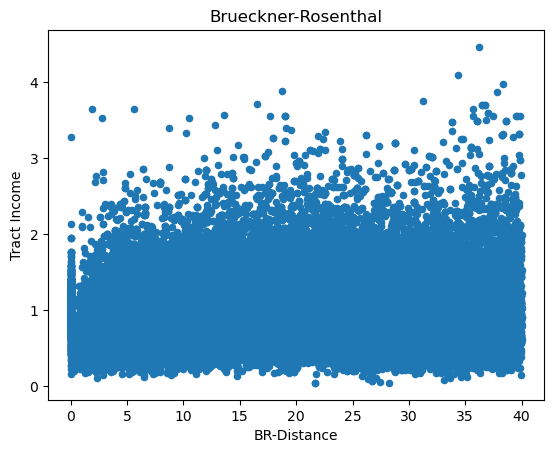

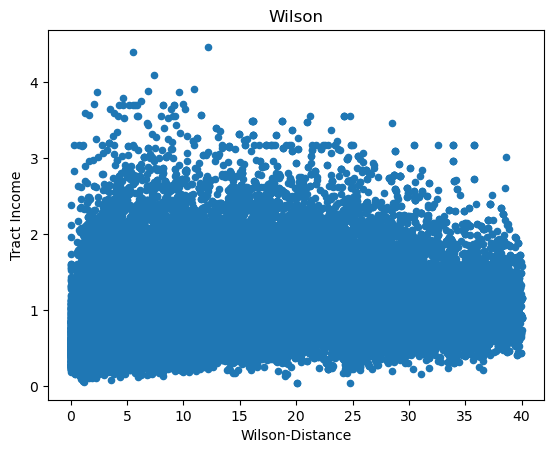

In [16]:
from matplotlib import pyplot as plt

br.plot(kind='scatter', x='distance', y='income', xlabel='BR-Distance', ylabel='Tract Income', title='Brueckner-Rosenthal')
wilson.plot(kind='scatter', x='distance', y='income', xlabel='Wilson-Distance', ylabel='Tract Income', title='Wilson')

Text(0.5, 1.0, 'Brueckner-Rosenthal')

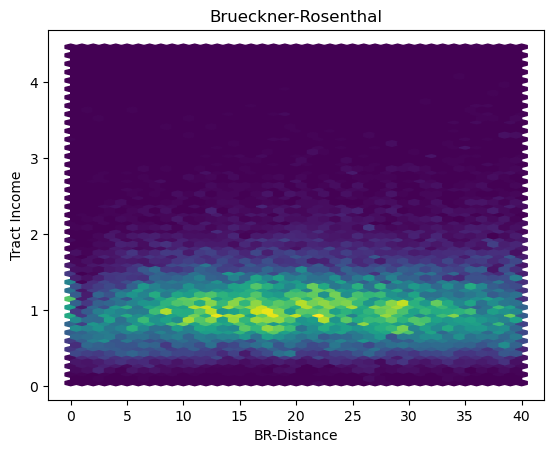

In [17]:
plt.hexbin(x=br['distance'], y=br['income'], gridsize=(40, 40))
plt.xlabel('BR-Distance')
plt.ylabel('Tract Income')
plt.title('Brueckner-Rosenthal')

Text(0.5, 1.0, 'Wilson')

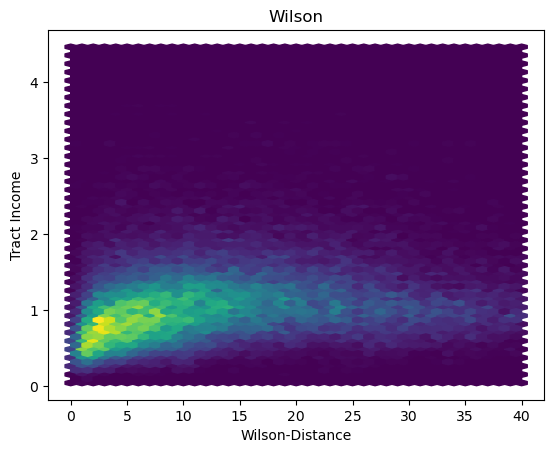

In [18]:
plt.hexbin(x=wilson['distance'], y=wilson['income'], gridsize=(40, 40))
plt.xlabel('Wilson-Distance')
plt.ylabel('Tract Income')
plt.title('Wilson')

In [19]:
def add_tract_counts(df: pd.DataFrame) -> pd.DataFrame:
    tract_counts =df.groupby('msa_code').count()['income']
    tract_counts = tract_counts.reset_index().rename({'income': 'tract_counts'}, axis=1)
    return pd.merge(right=df, left=tract_counts, left_on='msa_code', right_on='msa_code')

def discretize_distances(df: pd.DataFrame) -> pd.DataFrame:
    df['dist_bin'] = df['distance'].round()
    return df

def split_df_by_tract_counts(df: pd.DataFrame) -> Tuple[pd.DataFrame]:
    under_100 = df[df['tract_counts'] < 100]
    btw_100_500 = df[(df['tract_counts'] >= 100) & (df['tract_counts'] < 500)]
    btw_500_1000 = df[(df['tract_counts'] >= 500) & (df['tract_counts'] < 1000)]
    larger_1000 = df[df['tract_counts'] >= 1000]

    return (under_100, btw_100_500, btw_500_1000, larger_1000)

def plot_relative_income(df: pd.DataFrame, title: str, dist: str) -> None:
    df_dist_inc = df.groupby('dist_bin').mean()['income']
    plt.plot((df_dist_inc - df_dist_inc[0]) / df_dist_inc[0])
    plt.xlabel(f'{dist}-Distance from CBD (mi)')
    plt.ylabel('Median Income Compared to Mile Zero')
    plt.title(title)

def plot_housing_dist(df: pd.DataFrame) -> None:
    df.groupby('dist_bin').mean()[
    ['built_1999_2000', 
        'built_1995_1998', 
        'built_1990_1994', 
        'built_1980_1989', 
        'built_1970_1979', 
        'built_1960_1969', 
        'built_1950_1959', 
        'built_1940_1949', 
        'built_1939_earlier']
    ].plot(xlabel='Distance from CBD (mi)', ylabel='Mean Share of Housing Age')

def process_dataframe(df: pd.DataFrame) -> Tuple[pd.DataFrame]:
    return split_df_by_tract_counts(discretize_distances(add_tract_counts(df)))

In [20]:
under_100_br, btw_100_500_br, btw_500_1000_br, larger_1000_br = process_dataframe(br)
under_100_wilson, btw_100_500_wilson, btw_500_1000_wilson, larger_1000_wilson = process_dataframe(wilson)

/tmp/ipykernel_1343/176542597.py:19: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df_dist_inc = df.groupby('dist_bin').mean()['income']


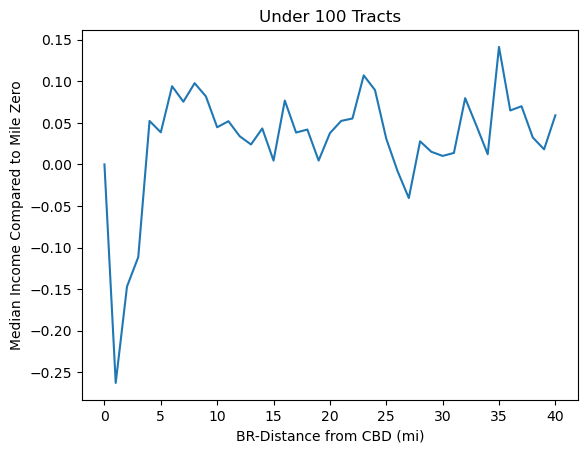

In [21]:
plot_relative_income(under_100_br, 'Under 100 Tracts', 'BR')

/tmp/ipykernel_1343/176542597.py:19: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df_dist_inc = df.groupby('dist_bin').mean()['income']


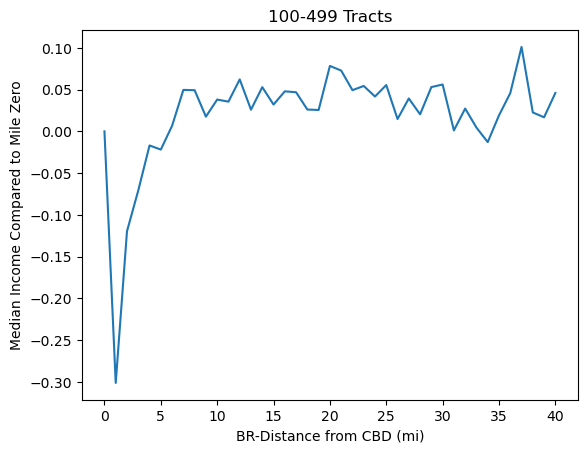

In [22]:
plot_relative_income(btw_100_500_br, '100-499 Tracts', 'BR')

/tmp/ipykernel_1343/176542597.py:19: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df_dist_inc = df.groupby('dist_bin').mean()['income']


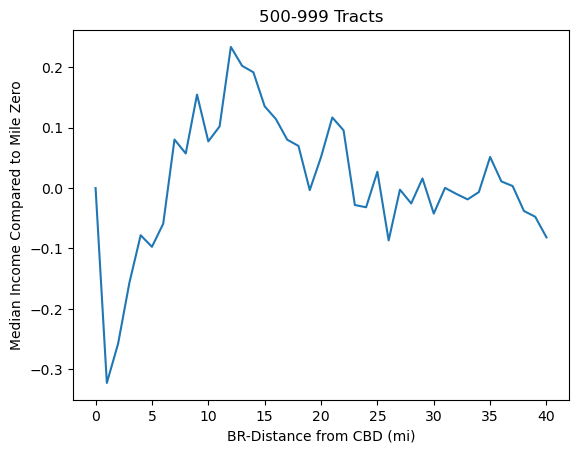

In [23]:
plot_relative_income(btw_500_1000_br, '500-999 Tracts', 'BR')

/tmp/ipykernel_1343/176542597.py:19: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df_dist_inc = df.groupby('dist_bin').mean()['income']


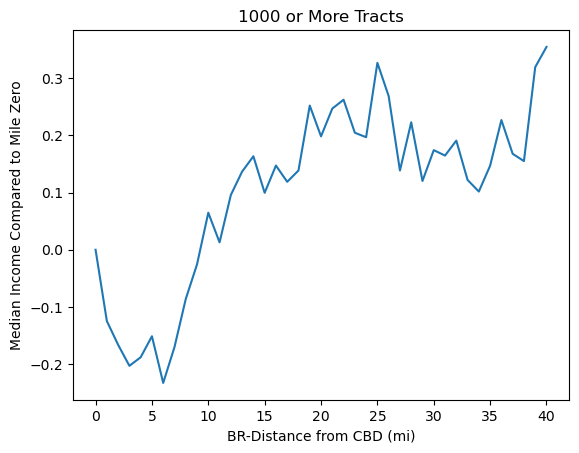

In [24]:
plot_relative_income(larger_1000_br, '1000 or More Tracts', 'BR')

/tmp/ipykernel_1343/176542597.py:19: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df_dist_inc = df.groupby('dist_bin').mean()['income']


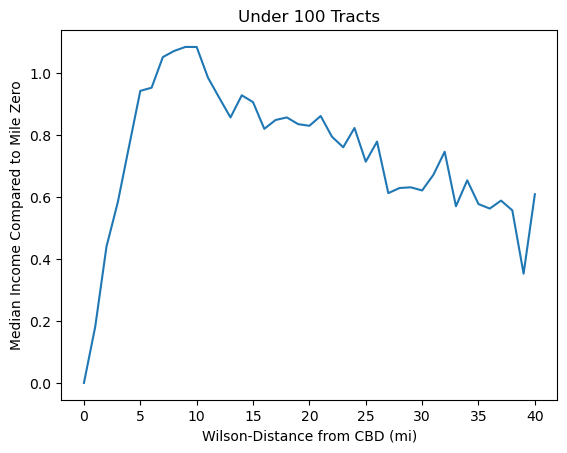

In [25]:
plot_relative_income(under_100_wilson, 'Under 100 Tracts', 'Wilson')

/tmp/ipykernel_1343/176542597.py:19: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df_dist_inc = df.groupby('dist_bin').mean()['income']


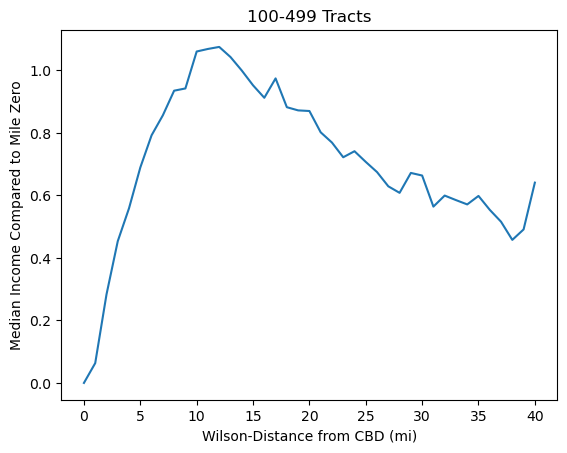

In [26]:
plot_relative_income(btw_100_500_wilson, '100-499 Tracts', 'Wilson')

/tmp/ipykernel_1343/176542597.py:19: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df_dist_inc = df.groupby('dist_bin').mean()['income']


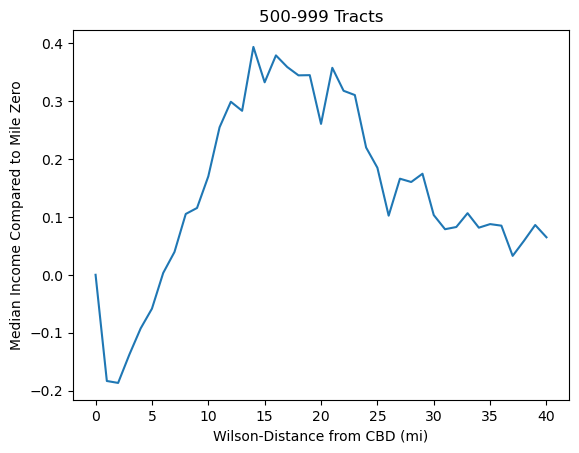

In [27]:
plot_relative_income(btw_500_1000_wilson, '500-999 Tracts', 'Wilson')

/tmp/ipykernel_1343/176542597.py:19: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df_dist_inc = df.groupby('dist_bin').mean()['income']


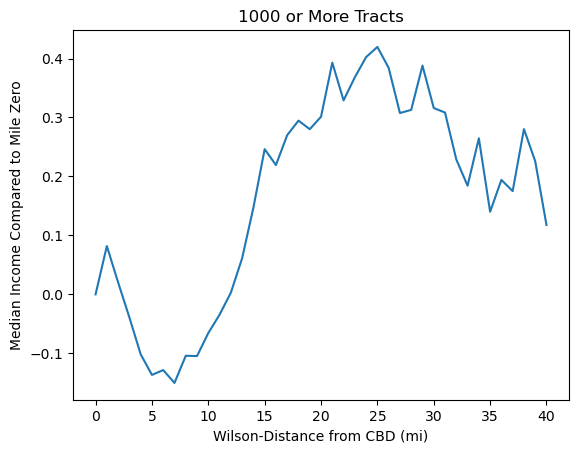

In [28]:
plot_relative_income(larger_1000_wilson, '1000 or More Tracts', 'Wilson')

## Mapping

In [29]:
def geofy_data(df: pd.DataFrame) -> geopandas.GeoDataFrame:
    ca_geo = geopandas.read_file('./data/CA_shapefile/tl_2010_06_tract00.shp')
    ca_geo = ca_geo[['CTIDFP00', 'geometry']]

    ca_geo['CTIDFP00'] = ca_geo['CTIDFP00'].astype(str).str.removeprefix('0')
    df['tract_id_2010'] = df['tract_id_2010'].astype(str)

    ca_geo = pd.merge(left=ca_geo, right=df, left_on='CTIDFP00', right_on='tract_id_2010')
    return ca_geo.dropna()